This notebook is for plotting snapshots plots corresponding to high and low NAO events. In particular, maps of anomlaies in wind stress, heat flux, SST, mixed-layer depth etc. are plotted.

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import cf_xarray
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, da_std = None, hatching = False, hatch_dense = 2, cfd_per = 1.96, vmin=-999, vmax=999, levels=9, 
             lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
             y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    if(hatching == True):
        #tmp_cfd = (da_std['confidence_upper'] - da_std['confidence_lower'])
        tmp_cfd = da_std['standard_error'] * cfd_per * 2.
        ax.contourf(da[lon], da[lat], np.abs(da) > np.abs(tmp_cfd), transform=ccrs.PlateCarree(), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
        
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return p

In [3]:
# Read data for NAO and compute seasonal values

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly_new.nc")

#NAO_season = ds_NAO['NAO'].copy()
NAO_season = (ds_NAO['P_south'] - ds_NAO['P_north']) # for NAO indices in pa

tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

%time NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 33.5 ms


In [4]:
NAO_cut = 1300. # in hpa (for normalised NAO indices, use 2.5 cut-off to be consistent with other scripts)

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    print('NAOp = ',c_NAOp, ', NAOn = ', c_NAOn) 

print('Total NAO positive members = ', count_NAOp)
print('Total NAO negative members = ', count_NAOn)

NAOp =  34 , NAOn =  49
NAOp =  39 , NAOn =  44
NAOp =  41 , NAOn =  40
Total NAO positive members =  114
Total NAO negative members =  133


In [5]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['tos']

case_list = ['NAOp']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
#ds_NAOn = xr.merge(ds_NAOn)

#ds_NAOp = ds_NAOp.mean('comp')
#ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

<xarray.Dataset>
Dimensions:    (j: 321, i: 361, comp: 114, time: 101)
Coordinates:
  * j          (j) int32 780 781 782 783 784 785 ... 1096 1097 1098 1099 1100
  * i          (i) int32 810 811 812 813 814 815 ... 1166 1167 1168 1169 1170
    latitude   (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Dimensions without coordinates: comp, time
Data variables:
    tos        (comp, time, j, i) float32 dask.array<chunksize=(114, 1, 321, 361), meta=np.ndarray>


#### Figure 1

In figure 1, we plot sesonal timeseries of NAO indices for selected members (both NAO+ and NAO- cases). In addition, DJFM means of surface diagnostics are plotted to see immediate effect of NAO conditions.

Hatching is shown to indicate the regions where the signal is significant at 95% confidence interval.

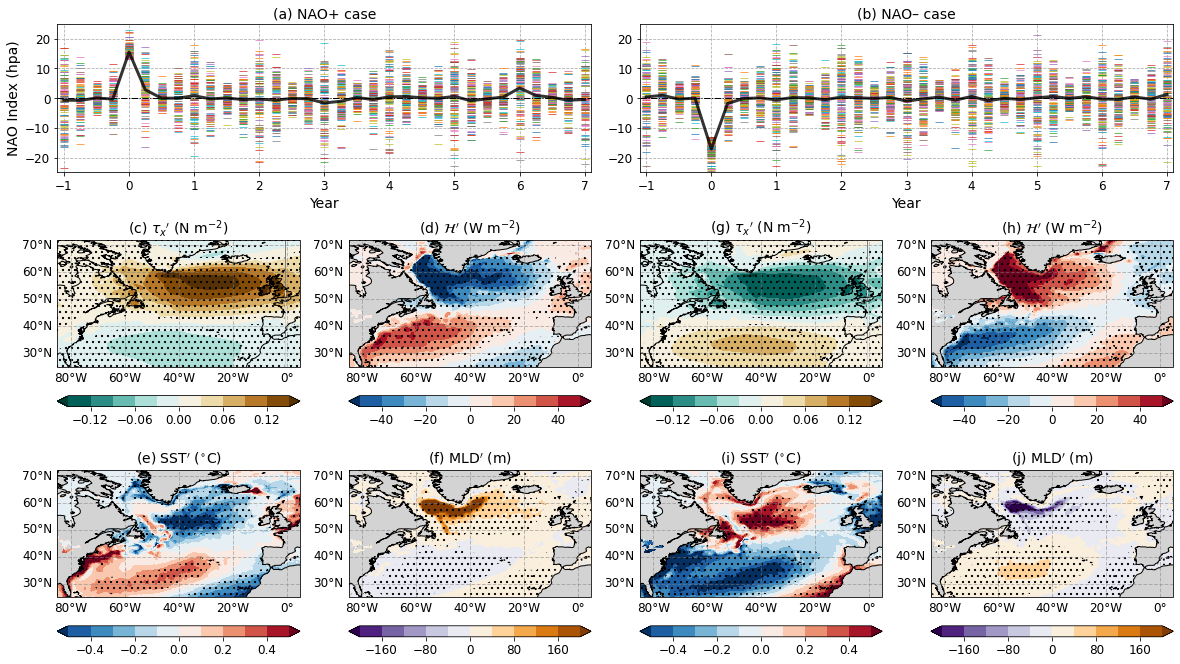

In [6]:
# With bootstrapping and 95% confidence intervals

grid1 = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[20,12])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = [r'${\tau_x}^{\prime}$ (N m$^{-2}$)', r'${\mathcal{H}}^{\prime}$ (W m$^{-2}$)', r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m)']
val = [0.15, 50., 0.5, 200.]

col_map = [cmaps.MPL_BrBG_r, cmaps.MPL_RdBu_r, cmaps.MPL_RdBu_r, cmaps.MPL_PuOr_r]

lat_lon_ext = [-85., 5., 25., 72.]

case_list = ['NAOp', 'NAOn']
tim_ind =4

cfd_per = 1.98 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

NAO_cut = 1300.

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

for case in case_list: 

    count = 1

    for var in var_list:

        titl = str(name[count])
        
        d = xr.open_dataset(data_dir + "Bootstrap_" + case + "_" + var + ".nc")
        d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.)
        tmp = d[var] 
        
        # get seasonl mean for the relavant data
        if (case == 'NAOp'): 
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2], projection=ccrs.PlateCarree(),facecolor='grey')
            titl = '(' + chr(99+count) + ') ' + str(name[count])
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2 + 2], projection=ccrs.PlateCarree(),facecolor='grey')
            titl = '(' + chr(103+count) + ') ' + str(name[count])
            
        p = plot_sec(ax, tmp, da_std = d, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 11,
                     lon='longitude', lat='latitude', cmap=col_map[count], title=titl, orien='horizontal')

        count = count + 1
    
    d = xr.open_dataset(data_dir + "Bootstrap_" + case + "_tauu.nc")
    tmp = d['tauu'] 
        
    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
        titl = '(c) ' + str(name[0])
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
        titl = '(g) ' + str(name[0])

    p = plot_sec(ax, tmp, da_std = d, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense,
                 vmin=-val[0], vmax=val[0],  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='lon', lat='lat', cmap=col_map[0], title=titl, orien='horizontal')

# plot NAO timeseries 
for i in range(0,2):
    
    tmp_mean = []
    
    ax = fig.add_subplot(grid1[0, (0+2*i):2*(i+1)])
    
    if(i==0):
    
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                    
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) >= NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)
                
    elif(i==1):
        
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) <= -NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7) 
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)

    ax.grid('on', ls='--')
    ax.set_xlabel('Year',  fontsize=14)
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_ylim([-25., 25.])
    if(i==0):
        plt.title('(a) NAO+ case', fontsize=14)
        ax.axhline(y=0., ls='-.', lw=1., color='k');
        ax.set_ylabel('NAO Index (hpa)',  fontsize=14)
    if(i==1):
        plt.title('(b) NAO– case', fontsize=14)
        ax.axhline(y=-0., ls='-.', lw=1., color='k');
        
    ax.set_xlim([-1.1, 7.1])
    
    bbox=plt.gca().get_position()
    offset=.05
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5, bbox.x1-bbox.x0 - offset*0.0, bbox.y1 - bbox.y0 - offset])

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.pdf', dpi=300,bbox_inches='tight');

#### Figure 2

In figure 2, time evolution of anomalies in upper ocean het content, surface heat flux, SST, MLD, and overturning (both in depth and sigma space) are plotted. This is to show the long-term impacts of NAO extremes.  

In [7]:
# Get correct sigma levels for overturning 

def density_levels(density_min=0., density_max=35.):
    
    """Define density levels
    Parameters
    ----------
    density_min : float value for minimum density
    density_max : float value for maximum density
    
    Returns
    -------
    sigma_levels : numpy array for density levels
    """

    density_rang1 = np.arange(density_min, 20., 2.0)
    density_rang2 = np.arange(20., 23.1, 1.)
    density_rang3 = np.arange(23.2, 26., 0.2)
    density_rang4 = np.arange(26.1, 28., 0.1)
    density_rang5 = np.arange(28.0, 28.8, 0.2)
    density_rang6 = np.arange(29.0, density_max, 1.)
    
    sigma_levels = np.concatenate((density_rang1 ,density_rang2, density_rang3, density_rang4, 
                                   density_rang5, density_rang6))
    
    return sigma_levels

# get sigma levels
sigma_min, sigma_max = (15., 31.1) 
target_sigma_levels = density_levels(density_min=sigma_min, density_max=sigma_max)

print(target_sigma_levels)

[15.  17.  19.  20.  21.  22.  23.  23.2 23.4 23.6 23.8 24.  24.2 24.4
 24.6 24.8 25.  25.2 25.4 25.6 25.8 26.  26.1 26.2 26.3 26.4 26.5 26.6
 26.7 26.8 26.9 27.  27.1 27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.
 28.2 28.4 28.6 28.8 29.  30.  31. ]


In [8]:
rng_nl = target_sigma_levels[1:] * np.arange(0, len(target_sigma_levels)-1)**2
print(rng_nl.shape)

print([target_sigma_levels[16], target_sigma_levels[26], target_sigma_levels[31], target_sigma_levels[34], target_sigma_levels[37]])

(48,)
[24.999999999999993, 26.500000000000007, 27.000000000000014, 27.30000000000002, 27.600000000000023]


In [9]:
# corret levels of depth for overturning

lev_bound = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Test_Data/nemo_av830o_1m_19810301-19810401_diaptr.nc")

dz = lev_bound['deptht_bounds'].diff('axis_nbounds').compute()
print(dz.isel(axis_nbounds=0).values[0:5])

[1.0239066 1.0792834 1.1481192 1.2337434 1.3401852]


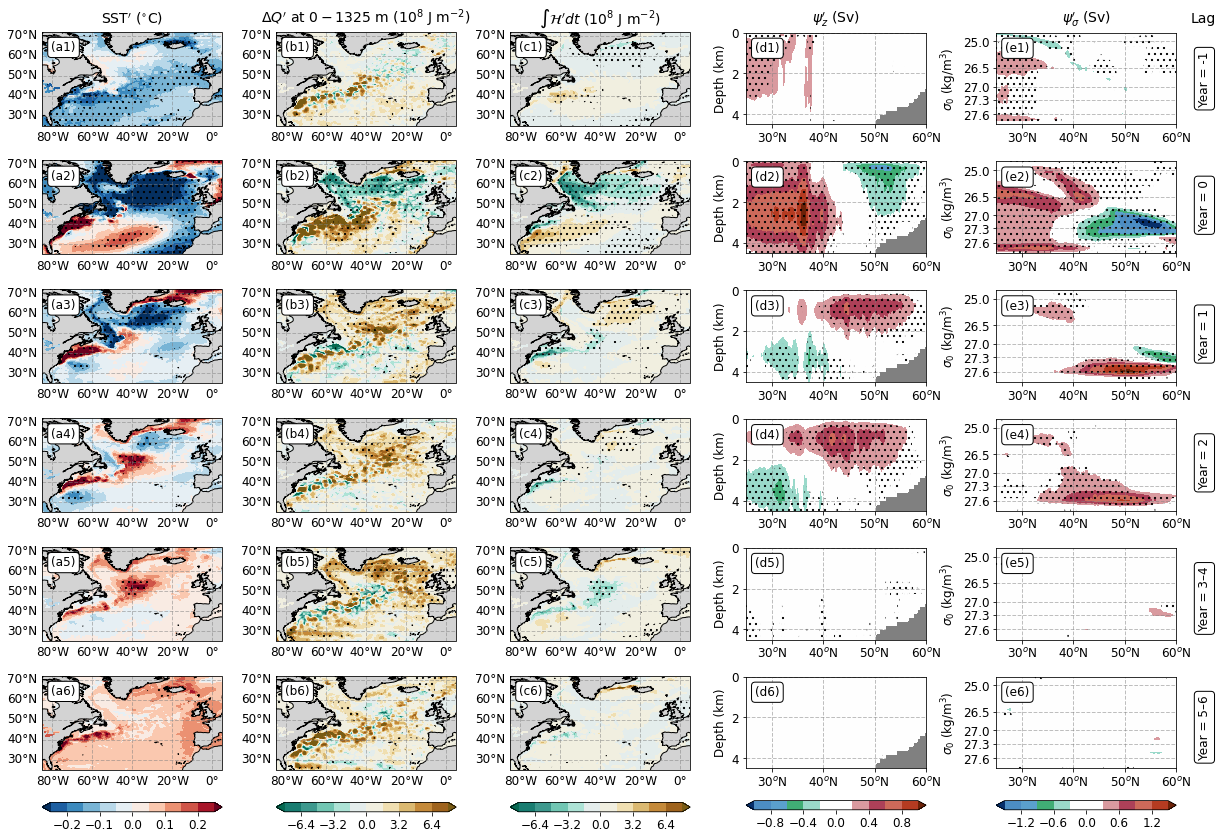

In [26]:
# With bootstrapping and 95% confidence interval

#plt.rcParams['hatch.linewidth'] = 1.5
#plt.rcParams['hatch.color'] = 'black'

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

grid1 = plt.GridSpec(6, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,14])

name = [r'$\Delta Q^{\prime}$ at $0-1325$ m ($10^{8}$ J m$^{-2}$)', r'$\int {\mathcal{H}}^{\prime} dt$ ($10^{8}$ J m$^{-2}$)', 
        r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m) in JFM', 
        r'$\psi_z^{\prime}$ (Sv)', r'$\psi_{\sigma}^{\prime}$ (Sv)']


d = xr.open_dataset(data_dir + "Bootstrap_NAOp_tos_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):
    
    tmp = d['tos'].isel(year=i)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['tos_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['tos_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['tos_standard_error'].isel(year=i)
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
    
    if(i==0):
        titl = str(name[2])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-0.25, vmax=0.25,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[0], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(a'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

d = xr.open_dataset(data_dir + "Bootstrap_NAOp_Heat_Budget_new_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):

    tmp = d['Heat_Content_1300'].isel(year=i) / 1e8
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i) / 1e8
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i) / 1e8
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i) / 1e8
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[1], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(b'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)


d = xr.open_dataset(data_dir + "Bootstrap_NAOp_hfds_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):
    
    tmp = d['hfds'].isel(year=i) / 1e8
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['hfds_confidence_lower'].isel(year=i) / 1e8
    d_std['confidence_upper'] = d['hfds_confidence_upper'].isel(year=i) / 1e8
    d_std['standard_error'] = d['hfds_standard_error'].isel(year=i) / 1e8
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[1])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8, 
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[1], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(c'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# overturning contours

d = xr.open_dataset(data_dir + "Bootstrap_NAOp_Overturning_MHT_annual.nc")

for i in range(0,6):
    
    tmp = d['Overturning_z'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Overturning_z_confidence_lower'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std['confidence_upper'] = d['Overturning_z_confidence_upper'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std['standard_error'] = d['Overturning_z_standard_error'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    
    d_std['Density_z'] = d['Density_z'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    
    tmp = tmp.isel(j_c=slice(0,303)) / 1e6
    tmp = tmp.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    
    tmp = tmp.drop('lev').assign_coords(lev=d['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    if(i==0):
        titl = str(name[4])
    else: 
        titl = ' '
        
    
    ax = fig.add_subplot(grid1[i, 3], facecolor='grey')
    p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 11, vmin = -1.0, vmax = 1.0,
                          cmap=col_map[2], add_labels=False, add_colorbar=False, extend='both')
    
    tmp_cfd = d_std['standard_error'].isel(j_c=slice(0,303)) * cfd_per * 2. / 1e6
    tmp_cfd = tmp_cfd.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev=d['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    ax.contourf(tmp['j_c'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'], linewidth=2., extend='lower')
    
    #CS = ax.contour(tmp['j_c'], tmp['lev'], d_std['Density_z'].isel(j_c=slice(0,303)), [27.2, 27.6, 27.65], linewidths=2., colors='darkslategray')
    #manual_locations = [(-1, -1.4), (-0.62, -0.7), (-2, 0.5)]
    #ax.clabel(CS, inline=True, fontsize=10) #, manual=manual_locations)
        
    ax.set_ylabel('Depth (km)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    plt.yticks(np.arange(0,5000,2000), [r'0', r'2', r'4'])
    ax.set_ylim([0., 4500.])
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    #plt.title(titl, fontsize=12)
    ax.set_title(titl, pad=10, fontsize=14)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.05, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(d'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,6):
    
    tmp = d['Overturning_sigma'].isel(year=i) / 1e6
    
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Overturning_sigma_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['Overturning_sigma_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['Overturning_sigma_standard_error'].isel(year=i)
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    
    rng_nl = target_sigma_levels[1:] * np.arange(0, len(d['sigma0']))**2
    tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    if(i==0):
        titl = str(name[5]) #+ '\n \n (e1)'  
    else: 
        titl = ' ' #(e' + str(i+1) + ')'
        
    
    ax = fig.add_subplot(grid1[i, 4])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 11, vmin = -1.5, vmax = 1.5,
                          cmap=col_map[2], add_labels=False, add_colorbar=False, extend='both')
    
    tmp_cfd = d_std['standard_error'].isel(j_c=slice(0,303)) * cfd_per * 2. / 1e6
    #tmp_cfd = (d_std['confidence_upper'] - d_std['confidence_lower']).isel(j_c=slice(0,303)) / 1e6
    tmp_cfd = tmp_cfd.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    tmp_cfd = tmp_cfd.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    ax.contourf(tmp['j_c'], tmp['sigma0'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'], extend='upper')
    
    ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    ax.set_ylim([2000., 40000.])
    plt.yticks([rng_nl[15], rng_nl[25], rng_nl[30], rng_nl[33], rng_nl[36]], [25.0, 26.5, 27.0, 27.3, 27.6])
    
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    ax.set_title(titl, pad=10, fontsize=14)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.5, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(e'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    if(i==0):
        ax.text(1.08, 1.23, 'Lag', transform=ax.transAxes, fontsize=14,
                verticalalignment='top')
    
    props = dict(boxstyle='round', facecolor='white')
    if(i <= 3):
        titl = 'Year = '+str(i-1)
        j=0
    else:
        titl = 'Year = '+str(i-1+j) + '–' + str(i+j)
        j=j+1
        
    ax.text(1.12, 0.8, titl, transform=ax.transAxes, fontsize=12, rotation =90,
            verticalalignment='top', bbox=props)
    
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.pdf', dpi=300,bbox_inches='tight');

In [10]:
print(d)

<xarray.Dataset>
Dimensions:                             (year: 6, sigma0_outer: 49, j_c: 450,
                                         lev: 75, sigma0: 48)
Coordinates:
  * j_c                                 (j_c) int32 699 700 701 ... 1147 1148
  * sigma0                              (sigma0) float64 16.0 18.0 ... 29.5 30.5
  * lev                                 (lev) float64 0.5058 1.556 ... 5.902e+03
  * sigma0_outer                        (sigma0_outer) float64 15.0 ... 31.0
Dimensions without coordinates: year
Data variables:
    Depth_sigma                         (year, sigma0_outer, j_c) float32 ...
    Density_z                           (year, lev, j_c) float32 ...
    latitude                            (j_c) float32 ...
    Overturning_z                       (year, lev, j_c) float32 ...
    Overturning_z_standard_error        (year, lev, j_c) float32 ...
    Overturning_z_confidence_lower      (year, lev, j_c) float32 ...
    Overturning_z_confidence_upper      (year, l

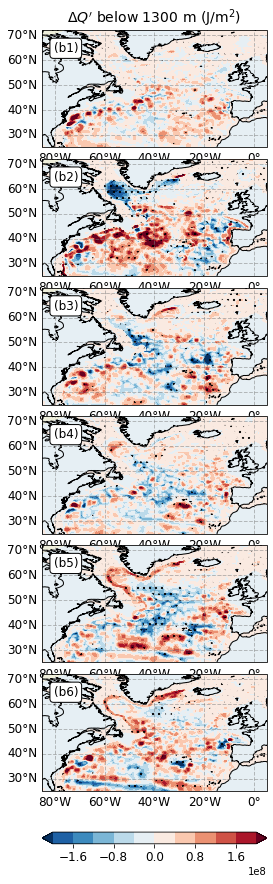

In [22]:
# With bootstrapping and 95% confidence interval

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

grid1 = plt.GridSpec(6, 1, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[6,14])

name = [r'$\Delta Q^{\prime}$ below 1300 m (J/m$^2$)']

d = xr.open_dataset(data_dir + "Bootstrap_NAOp_Heat_Budget_new_annual.nc")

for i in range(0,6):

    tmp = d['Heat_Content_1300_full'].isel(year=i)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i)
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-200.e6, vmax=200.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(b'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

#### Fiture 2 supporting document

Same as Figure 2 but for NAO- case 

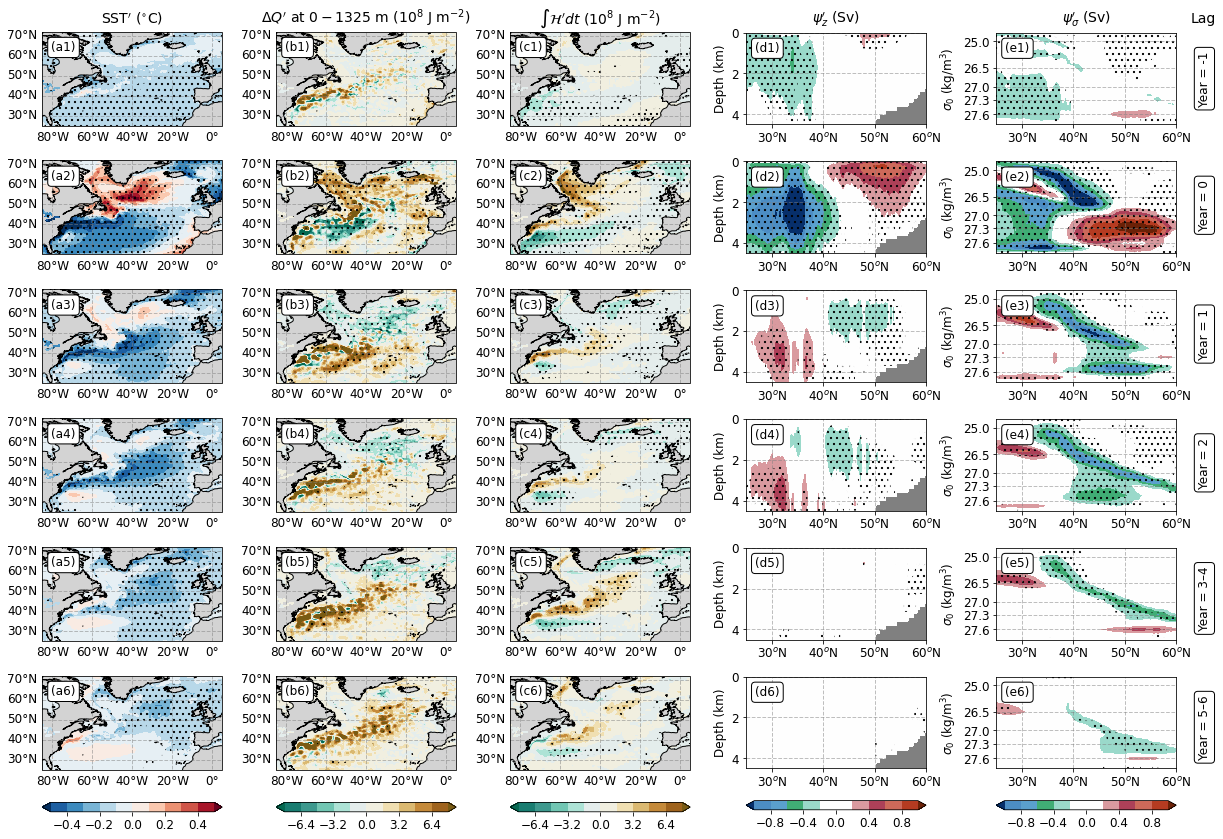

In [27]:
# With bootstrapping and 95% confidence interval

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

grid1 = plt.GridSpec(6, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,14])

name = [r'$\Delta Q^{\prime}$ at $0-1325$ m ($10^{8}$ J m$^{-2}$)', r'$\int {\mathcal{H}}^{\prime} dt$ ($10^{8}$ J m$^{-2}$)', 
        r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m) in JFM', 
        r'$\psi_z^{\prime}$ (Sv)', r'$\psi_{\sigma}^{\prime}$ (Sv)']


d = xr.open_dataset(data_dir + "Bootstrap_NAOn_tos_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):
    
    tmp = d['tos'].isel(year=i)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['tos_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['tos_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['tos_standard_error'].isel(year=i)
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
    
    if(i==0):
        titl = str(name[2])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-0.5, vmax=0.5,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[0], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(a'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

d = xr.open_dataset(data_dir + "Bootstrap_NAOn_Heat_Budget_new_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):

    tmp = d['Heat_Content_1300'].isel(year=i) / 1e8
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i) / 1e8
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i) / 1e8
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i) / 1e8
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[1], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(b'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)


d = xr.open_dataset(data_dir + "Bootstrap_NAOn_hfds_annual.nc")
d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

for i in range(0,6):
    
    tmp = d['hfds'].isel(year=i) / 1e8
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['hfds_confidence_lower'].isel(year=i) / 1e8
    d_std['confidence_upper'] = d['hfds_confidence_upper'].isel(year=i) / 1e8
    d_std['standard_error'] = d['hfds_standard_error'].isel(year=i) / 1e8
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[1])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8, 
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap=col_map[1], 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(c'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# overturning contours

d = xr.open_dataset(data_dir + "Bootstrap_NAOn_Overturning_MHT_annual.nc")

for i in range(0,6):
    
    tmp = d['Overturning_z'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Overturning_z_confidence_lower'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std['confidence_upper'] = d['Overturning_z_confidence_upper'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    d_std['standard_error'] = d['Overturning_z_standard_error'].isel(year=i).where(d['Density_z'].isel(year=i)>20.)
    
    tmp = tmp.isel(j_c=slice(0,303)) / 1e6
    tmp = tmp.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    
    tmp = tmp.drop('lev').assign_coords(lev=d['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    if(i==0):
        titl = str(name[4])
    else: 
        titl = ' '
        
    
    ax = fig.add_subplot(grid1[i, 3], facecolor='grey')
    p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 11, vmin = -1., vmax = 1.,
                          cmap=col_map[2], add_labels=False, add_colorbar=False, extend='both')
    
    tmp_cfd = d_std['standard_error'].isel(j_c=slice(0,303)) * cfd_per * 2. / 1e6
    #tmp_cfd = (d_std['confidence_upper'] - d_std['confidence_lower']).isel(j_c=slice(0,303)) / 1e6
    tmp_cfd = tmp_cfd.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev=d['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    ax.contourf(tmp['j_c'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
        
    ax.set_ylabel('Depth (km)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    plt.yticks(np.arange(0,5000,2000), [r'0', r'2', r'4'])
    ax.set_ylim([0., 4500.])
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    #plt.title(titl, fontsize=12)
    ax.set_title(titl, pad=10, fontsize=14)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.05, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(d'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,6):
    
    tmp = d['Overturning_sigma'].isel(year=i) / 1e6
    
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Overturning_sigma_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['Overturning_sigma_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['Overturning_sigma_standard_error'].isel(year=i)
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    
    rng_nl = target_sigma_levels[1:] * np.arange(0, len(d['sigma0']))**2
    tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    if(i==0):
        titl = str(name[5]) #+ '\n \n (e1)'  
    else: 
        titl = ' ' #(e' + str(i+1) + ')'
        
    
    ax = fig.add_subplot(grid1[i, 4])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 11, vmin = -1., vmax = 1.,
                          cmap=col_map[2], add_labels=False, add_colorbar=False, extend='both')
    
    tmp_cfd = d_std['standard_error'].isel(j_c=slice(0,303)) * cfd_per * 2. / 1e6
    #tmp_cfd = (d_std['confidence_upper'] - d_std['confidence_lower']).isel(j_c=slice(0,303)) / 1e6
    tmp_cfd = tmp_cfd.assign_coords(j_c=d['latitude'].isel(j_c=slice(0,303)))
    tmp_cfd = tmp_cfd.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    ax.contourf(tmp['j_c'], tmp['sigma0'], (np.abs(tmp) > np.abs(tmp_cfd)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    
    ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    ax.set_ylim([2000., 40000.])
    plt.yticks([rng_nl[15], rng_nl[25], rng_nl[30], rng_nl[33], rng_nl[36]], [25.0, 26.5, 27.0, 27.3, 27.6])
    
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    ax.set_title(titl, pad=10, fontsize=14)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.5, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(e'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    if(i==0):
        ax.text(1.08, 1.23, 'Lag', transform=ax.transAxes, fontsize=14,
                verticalalignment='top')
    
    props = dict(boxstyle='round', facecolor='white')
    if(i <= 3):
        titl = 'Year = '+str(i-1)
        j=0
    else:
        titl = 'Year = '+str(i-1+j) + '–' + str(i+j)
        j=j+1
        
    ax.text(1.12, 0.8, titl, transform=ax.transAxes, fontsize=12, rotation =90,
            verticalalignment='top', bbox=props)
    
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2_support.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2_support.pdf', dpi=300,bbox_inches='tight');

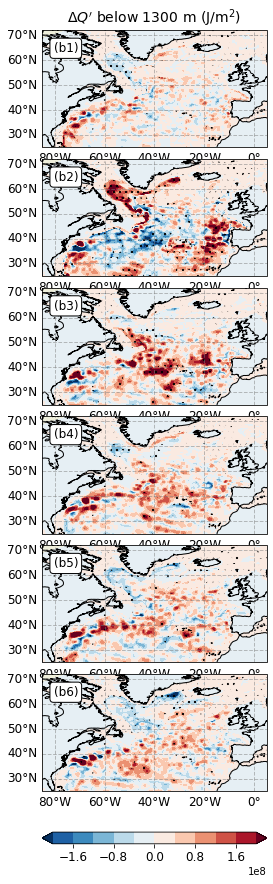

In [21]:
# With bootstrapping and 95% confidence interval

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

grid1 = plt.GridSpec(6, 1, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[6,14])

name = [r'$\Delta Q^{\prime}$ below 1300 m (J/m$^2$)']

d = xr.open_dataset(data_dir + "Bootstrap_NAOn_Heat_Budget_new_annual.nc")

for i in range(0,6):

    tmp = d['Heat_Content_1300_full'].isel(year=i)
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i)
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i)
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i)
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-200.e6, vmax=200.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '(b'+str(i+1)+')', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

## Figure 4

Testing some of the plots vertical sections of temperature anomalies.

In [2]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['thetao', 'so', 'vo']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(var == 'vo'):
            d = d.rename({'j':'j_c', 'longitude':'longitude_v', 'latitude':'latitude_v'})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")
dA = ds_grid.get(['area_t', 'dy_t']).isel(y=slice(780-699, 1100-699+1), 
                                          x=slice(810-749,1170-749+1)).rename({'y':'j', 'x':'i'})

dA_y = ds_grid.get(['area_v', 'dy_v']).isel(yv=slice(780-699, 1100-699+1), 
                                            x=slice(810-749,1170-749+1)).rename({'yv':'j_c', 'x':'i'})

ds_NAOp = xr.merge([ds_NAOp, dA, dA_y])

print(ds_NAOp)

<xarray.Dataset>
Dimensions:      (j: 321, i: 361, j_c: 321, lev: 75, time: 101)
Coordinates:
  * j            (j) int64 780 781 782 783 784 785 ... 1096 1097 1098 1099 1100
  * i            (i) int64 810 811 812 813 814 815 ... 1166 1167 1168 1169 1170
  * j_c          (j_c) int64 780 781 782 783 784 ... 1096 1097 1098 1099 1100
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude     (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude    (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    latitude_v   (j_c, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lat      (j, i) float32 ...
    nav_lon      (j, i) float32 ...
Dimensions without coordinates: time
Data variables:
    thetao       (time, lev, j, i) float32 dask.array<chunksize=(1, 75, 321, 361), meta=np.ndarray>
    so           (time, lev, j, i) fl

In [5]:
print(dA)

<xarray.Dataset>
Dimensions:  (j: 321, i: 361)
Coordinates:
    nav_lat  (j, i) float32 ...
    nav_lon  (j, i) float32 ...
Dimensions without coordinates: j, i
Data variables:
    area_t   (j, i) float32 ...
    dy_t     (j, i) float32 ...


(910.0, 955.0)

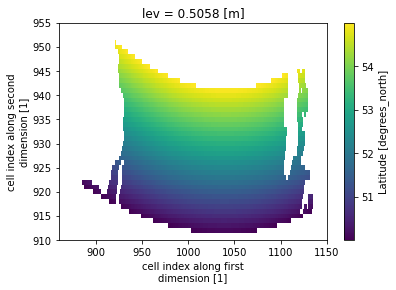

In [33]:
tmp = ds_NAOp['nav_lat'].where((ds_NAOp['thetao'].isel(time=0,lev=0) < 100.) & (ds_NAOp.nav_lat >=50.) &
                            (ds_NAOp.nav_lat <= 55.) & (ds_NAOp.nav_lon >=-70.) & (ds_NAOp.nav_lon <= -2.)).compute()

tmp.plot()
plt.xlim(860, 1150) # use these limites to save time
plt.ylim(910, 955)

<xarray.DataArray (lev: 75, j: 321, i: 361)>
dask.array<truediv, shape=(75, 321, 361), dtype=float32, chunksize=(75, 321, 361), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int64 780 781 782 783 784 785 ... 1096 1097 1098 1099 1100
  * i          (i) int64 810 811 812 813 814 815 ... 1166 1167 1168 1169 1170
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude   (j, i) float32 23.55 23.55 23.55 23.55 ... 72.55 72.47 72.39
    longitude  (j, i) float32 -84.5 -84.25 -84.0 -83.75 ... 28.07 28.36 28.65
    nav_lat    (j, i) float32 23.55 23.55 23.55 23.55 ... 72.55 72.47 72.39
    nav_lon    (j, i) float32 -84.5 -84.25 -84.0 -83.75 ... 28.07 28.36 28.65


(910.0, 955.0)

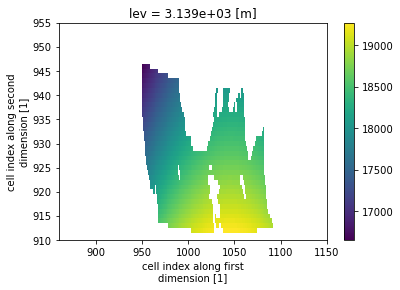

In [39]:
dy = ds_NAOp['dy_t'].where((ds_NAOp.nav_lat >=50.) &
                 (ds_NAOp.nav_lat <= 55.) & (ds_NAOp.nav_lon >=-70.) & (ds_NAOp.nav_lon <= -2.)).compute()

dy = ds_NAOp['thetao'].isel(time=0) * dy / ds_NAOp['thetao'].isel(time=0)

print(dy)

dy.isel(lev=60).plot()
plt.xlim(860, 1150) # use these limites to save time
plt.ylim(910, 955)

In [3]:
lat_lim = [50., 60.]
lon_lim = [-70., -2.]

dy = ds_NAOp['dy_t'].where((ds_NAOp['thetao'].isel(time=0,lev=0) < 100.) & (ds_NAOp.nav_lat >=50.) &
                 (ds_NAOp.nav_lat <= 55.) & (ds_NAOp.nav_lon >=-70.) & (ds_NAOp.nav_lon <= -2.)).compute()

dy = ds_NAOp['thetao'].isel(time=0) * dy / ds_NAOp['thetao'].isel(time=0)

Temp_NAOp = ((ds_NAOp['thetao'] * dy).mean('j') / 
             ( ds_NAOp['thetao'] * dy / ds_NAOp['thetao']).mean('j'))

Temp_NAOn = ((ds_NAOn['thetao'] * dy).mean('j') / 
             ( ds_NAOn['thetao'] * dy / ds_NAOn['thetao']).mean('j'))

lon = ((ds_NAOp['longitude'] * ds_NAOp['dy_t'].where((ds_NAOp.nav_lat >=50.) & (ds_NAOp.nav_lat <= 60.))).mean('j') / 
        ( ds_NAOp['dy_t'].where((ds_NAOp.nav_lat >=50.) & (ds_NAOp.nav_lat <= 60.))).mean('j')).drop(['i'])

Temp_NAOp = Temp_NAOp.drop('i').assign_coords(i=lon)
Temp_NAOn = Temp_NAOn.drop('i').assign_coords(i=lon)

so_NAOp = ((ds_NAOp['so'] * dy).mean('j') / 
             ( ds_NAOp['so'] * dy / ds_NAOp['so']).mean('j'))

so_NAOn = ((ds_NAOn['so'] * dy).mean('j') / 
             ( ds_NAOn['so'] * dy / ds_NAOn['so']).mean('j'))

so_NAOp = so_NAOp.drop('i').assign_coords(i=lon)
so_NAOn = so_NAOn.drop('i').assign_coords(i=lon)


print(Temp_NAOp, lon)

dy_v = ds_NAOp['dy_v'].where((ds_NAOp['vo'].isel(time=0,lev=0) < 100.) & (ds_NAOp.latitude_v >=50.) &
                 (ds_NAOp.latitude_v <= 55.) & (ds_NAOp.longitude_v >=-70.) & (ds_NAOp.longitude_v <= -2.)).compute()

V_NAOp = ((ds_NAOp['vo'] * dy_v).mean('j_c') / 
             ( ds_NAOp['vo'] * dy_v / ds_NAOp['vo']).mean('j_c'))

V_NAOn = ((ds_NAOn['vo'] * dy_v).mean('j_c') / 
             ( ds_NAOn['vo'] * dy_v / ds_NAOn['vo']).mean('j_c'))

lon_v = ((ds_NAOp['longitude_v'] * ds_NAOp['dy_v'].where((ds_NAOp.latitude_v >=50.) & (ds_NAOp.latitude_v <= 60.))).mean('j_c') / 
        ( ds_NAOp['dy_v'].where((ds_NAOp.latitude_v >=50.) & (ds_NAOp.latitude_v <= 60.))).mean('j_c')).drop(['i'])

V_NAOp = V_NAOp.drop('i').assign_coords(i=lon_v)
V_NAOn = V_NAOn.drop('i').assign_coords(i=lon_v)

print(V_NAOp)

<xarray.DataArray (time: 101, lev: 75, i: 361)>
dask.array<truediv, shape=(101, 75, 361), dtype=float32, chunksize=(1, 75, 361), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
  * i        (i) float32 -86.87 -86.61 -86.38 -86.14 ... 7.716 8.032 8.294 8.555
Dimensions without coordinates: time <xarray.DataArray (i: 361)>
dask.array<truediv, shape=(361,), dtype=float32, chunksize=(361,), chunktype=numpy.ndarray>
Dimensions without coordinates: i
<xarray.DataArray (time: 101, lev: 75, i: 361)>
dask.array<truediv, shape=(101, 75, 361), dtype=float32, chunksize=(1, 75, 361), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
  * i        (i) float32 -86.86 -86.63 -86.38 -86.16 ... 7.743 8.005 8.296 8.558
Dimensions without coordinates: time


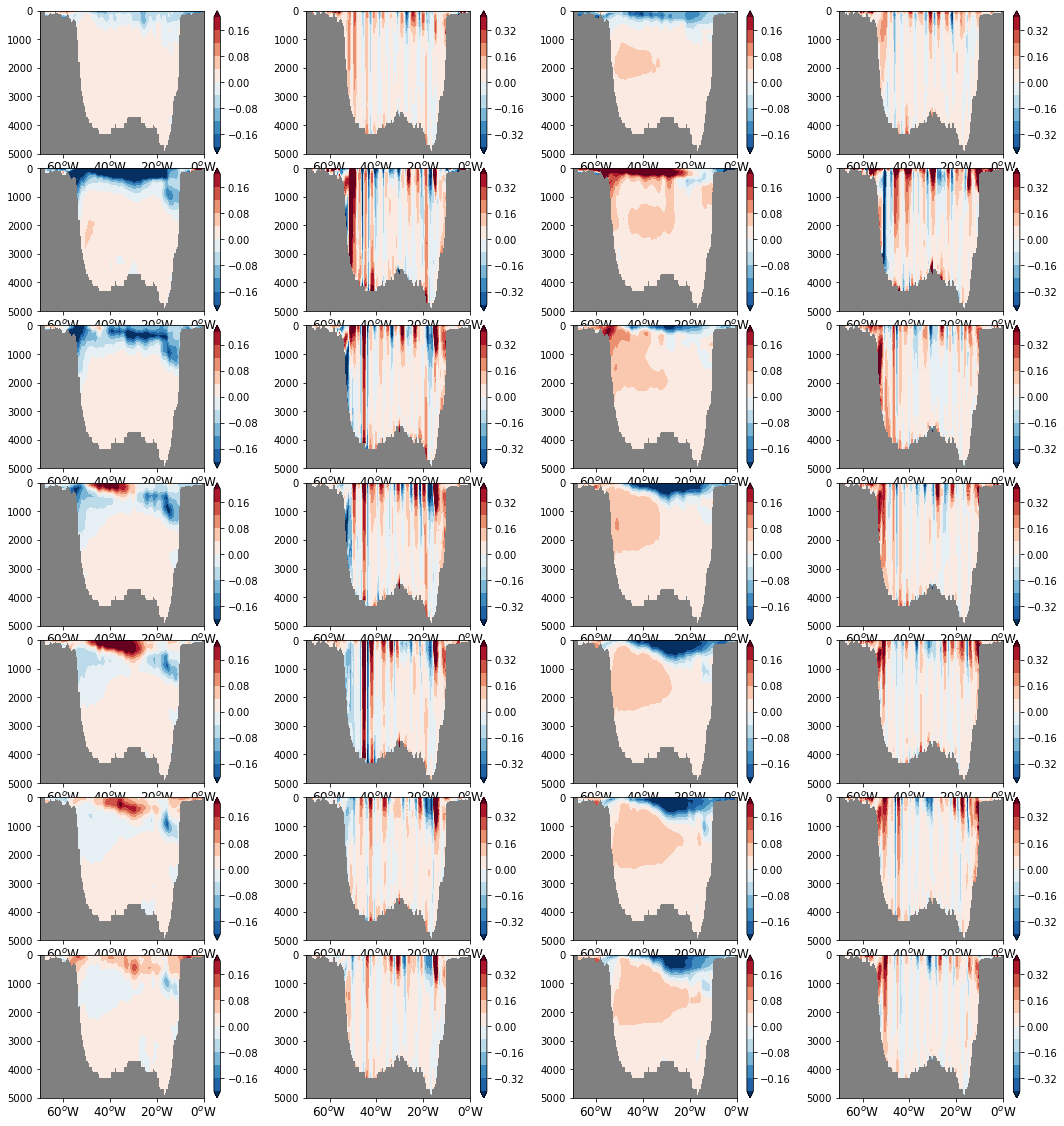

In [14]:
grid1 = plt.GridSpec(7, 4, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,20])

for i in range(0,7):
    
    tmp = Temp_NAOp.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.2, vmax = 0.2,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 5000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
    tmp = Temp_NAOn.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 2],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.2, vmax = 0.2,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 5000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
for i in range(0,7):
    
    tmp = V_NAOp.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') * 100. #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 1],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.4, vmax = 0.4,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    ax.set_ylim([0., 5000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
    tmp = V_NAOn.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') * 100. #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 3],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.4, vmax = 0.4,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 5000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()

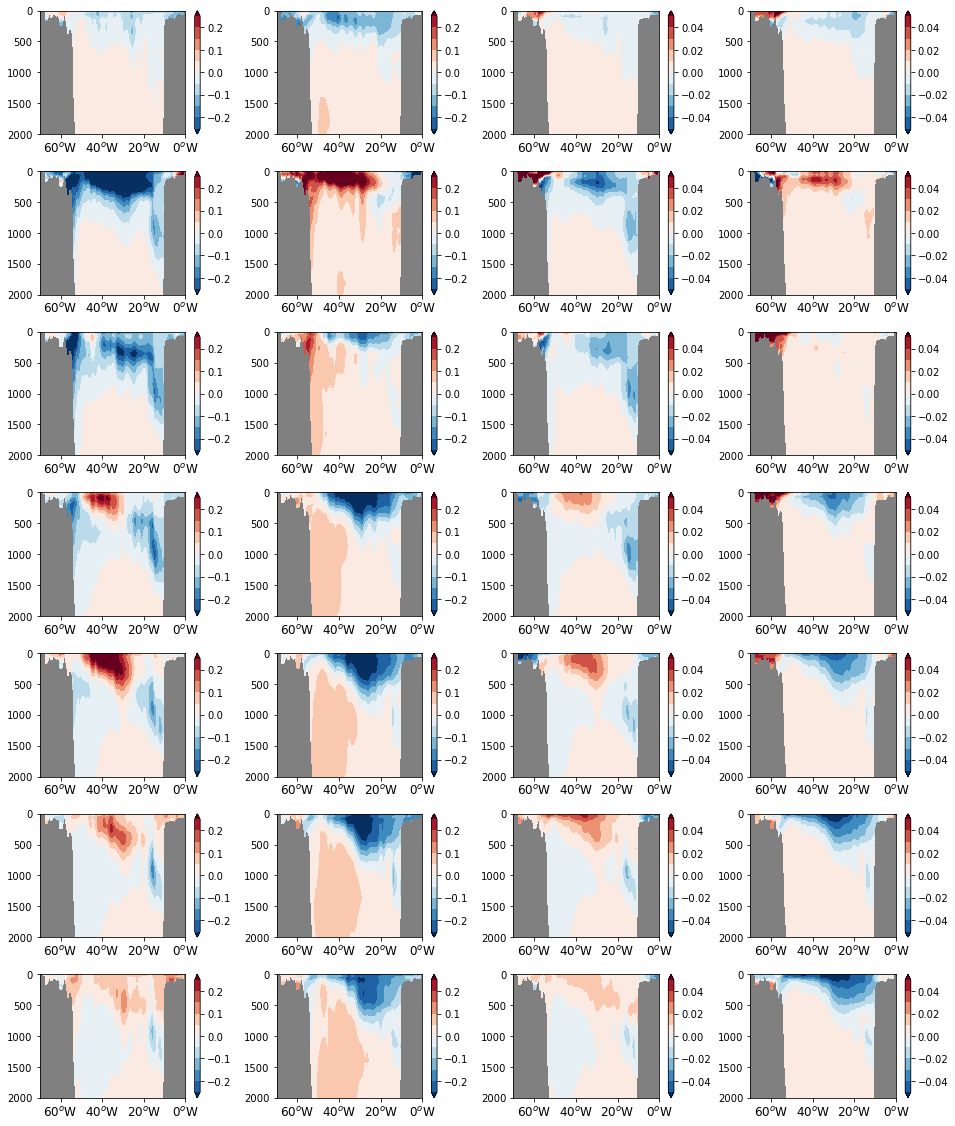

In [8]:
grid1 = plt.GridSpec(7, 4, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[16,20])

for i in range(0,7):
    
    tmp = Temp_NAOp.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.25, vmax = 0.25,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 2000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
    tmp = Temp_NAOn.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 1],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.25, vmax = 0.25,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 2000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
for i in range(0,7):
    
    tmp = so_NAOp.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 2],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.05, vmax = 0.05,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    ax.set_ylim([0., 2000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()
    
    tmp = so_NAOn.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 3],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.05, vmax = 0.05,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    ax.set_ylim([0., 2000.])
    ax.set_xlim([-70., 0.])
    
    plt.gca().invert_yaxis()

Text(1.3, 0.8, 'Lag Year = 3')

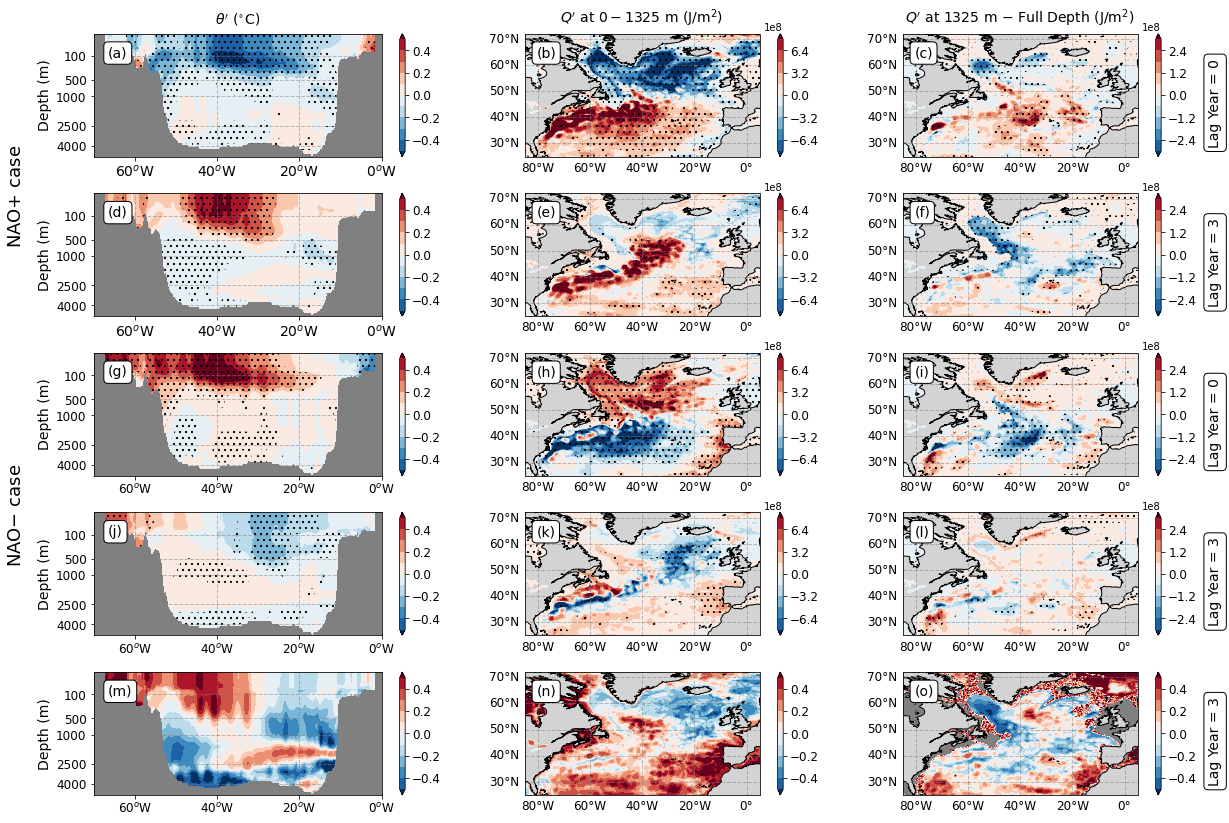

In [12]:
# With bootstrapping and confidence interval

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

grid1 = plt.GridSpec(5, 3, wspace=0.05, hspace=0.3)
fig = plt.figure(figsize=[20,14])

d1 = xr.open_dataset(data_dir + "../Composite_NAOp_thetao_Depth_Lon.nc", chunks={'time':1, 'comp':1})
d1 = d1.rename({'i':'im'})
lon = d1['longitude']

name = [r'$\theta^{\prime}$ ($^{\circ}$C)', r'$Q^{\prime}$ at $0-1325$ m (J/m$^2$)', 
        r'$Q^{\prime}$ at 1325 m $-$ Full Depth (J/m$^2$)'] 

# ------------ NAO+ case -------------------- #

d = xr.open_dataset(data_dir + "Bootstrap_NAOp_thetao_Depth_Lon.nc")
#d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

j = 0
for i in range(1, 5, 3):

    tmp = (d['Heat_Content_1300'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-800.e6, vmax=800.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(98+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    if(i == 1):
        ax.set_title(name[1], pad=10, fontsize=14)
    
    j = j + 1

j = 0
for i in range(1, 5, 3):

    tmp = (d['Heat_Content_1300_full'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-300.e6, vmax=300.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(99+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1
    
    if(i == 4):
        
        ax.text(1.3, 0.8, 'Lag Year = 3', transform=ax.transAxes, fontsize=14, rotation =90,
                verticalalignment='top', bbox=props)
        
    elif(i == 1):
        
        ax.text(1.3, 0.8, 'Lag Year = 0', transform=ax.transAxes, fontsize=14, rotation =90,
                verticalalignment='top', bbox=props)
        
        ax.set_title(name[2], pad=10, fontsize=14)


j = 0
for i in range(1, 5, 3):

    tmp = d['thetao'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.)
    tmp = tmp.drop('im').assign_coords(im=lon)
    tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax = fig.add_subplot(grid1[j, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -0.5, vmax = 0.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=12)
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    tmp_cfd = d['thetao_standard_error'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.) * cfd_per * 2.
    tmp_cfd = tmp_cfd.assign_coords(im=lon)
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax.contourf(tmp['im'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    
    plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
    ax.set_ylim([1., 5000.**0.4])
    ax.set_xlim([-70., 0.])
    
    ax.set_ylabel('Depth (m)', fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 14);
    
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
    plt.gca().invert_yaxis()
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(97+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1

    if(i == 1):
        
        ax.text(-0.3, 0.1, r'NAO$+$ case', transform=ax.transAxes, fontsize=18, rotation = 90,
                verticalalignment='top')
        
        ax.set_title(name[0], pad=10, fontsize=14)
        
# ------------ NAO- case -------------------- # 

d = xr.open_dataset(data_dir + "Bootstrap_NAOn_thetao_Depth_Lon.nc")
#d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

j = 2
for i in range(1, 5, 3):

    tmp = (d['Heat_Content_1300'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-800.e6, vmax=800.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11,  lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(98+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1


j = 2
for i in range(1, 5, 3):

    tmp = d['thetao'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.)
    tmp = tmp.drop('im').assign_coords(im=lon)
    tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax = fig.add_subplot(grid1[j, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -0.5, vmax = 0.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=12)
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    tmp_cfd = d['thetao_standard_error'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.) * cfd_per * 2.
    tmp_cfd = tmp_cfd.assign_coords(im=lon)
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax.contourf(tmp['im'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    
    plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
    ax.set_ylim([1., 5000.**0.4])
    ax.set_xlim([-70., 0.])
    
    ax.set_ylabel('Depth (m)', fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
    plt.gca().invert_yaxis()
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(97+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1

    if(i == 1):
        
        ax.text(-0.3, 0.1, r'NAO$-$ case', transform=ax.transAxes, fontsize=18, rotation = 90,
                verticalalignment='top')
    
j = 2
for i in range(1, 5, 3):

    tmp = (d['Heat_Content_1300_full'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-300.e6, vmax=300.e6,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(99+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1
    
    if(i == 4):
        
        ax.text(1.3, 0.8, 'Lag Year = 3', transform=ax.transAxes, fontsize=14, rotation =90,
                verticalalignment='top', bbox=props)
        
    elif(i == 1):
        
        ax.text(1.3, 0.8, 'Lag Year = 0', transform=ax.transAxes, fontsize=14, rotation =90,
                verticalalignment='top', bbox=props)

# ------------ NAO+ + NAO- cases for lag year = 3 -------------------- # 

count_NAOp = 114
count_NAOn = 133

cb_lim = 0.5
        
dp = xr.open_dataset(data_dir + "Bootstrap_NAOp_thetao_Depth_Lon.nc")
dn = xr.open_dataset(data_dir + "Bootstrap_NAOn_thetao_Depth_Lon.nc")

tmp = (dp['thetao'] / (dp['thetao_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['thetao'] / (dn['thetao_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(d1['thetao'].isel(time=0, comp=0) < 100.)
tmp = tmp.drop('im').assign_coords(im=lon)
tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
ax = fig.add_subplot(grid1[4, 0],facecolor='grey')
    
p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -cb_lim, vmax = cb_lim,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', r'$20^o$W', r'$0^o$W'], fontsize = 12);

plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
ax.set_ylim([1., 5000.**0.4])
ax.set_xlim([-70., 0.])
    
ax.set_ylabel('Depth (m)', fontsize=14)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);

ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
plt.gca().invert_yaxis()
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(m)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


tmp = (dp['Heat_Content_1300'] / (dp['Heat_Content_1300_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['Heat_Content_1300'] / (dn['Heat_Content_1300_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.)
    
ax = fig.add_subplot(grid1[4, 1], projection=ccrs.PlateCarree(),facecolor='grey')
p = plot_sec(ax, tmp, da_std = d_std, hatching = False, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-cb_lim, vmax=cb_lim,  
             lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
             title=' ', orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(n)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

tmp = (dp['Heat_Content_1300_full'] / (dp['Heat_Content_1300_full_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['Heat_Content_1300_full'] / (dn['Heat_Content_1300_full_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.)
    
ax = fig.add_subplot(grid1[4, 2], projection=ccrs.PlateCarree(),facecolor='grey')
p = plot_sec(ax, tmp, da_std = d_std, hatching = False, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-cb_lim, vmax=cb_lim,  
            lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
            title=' ', orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(o)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.text(1.3, 0.8, 'Lag Year = 3', transform=ax.transAxes, fontsize=14, rotation =90, verticalalignment='top', bbox=props)

#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure4.png', dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure4.pdf', dpi=300,bbox_inches='tight');

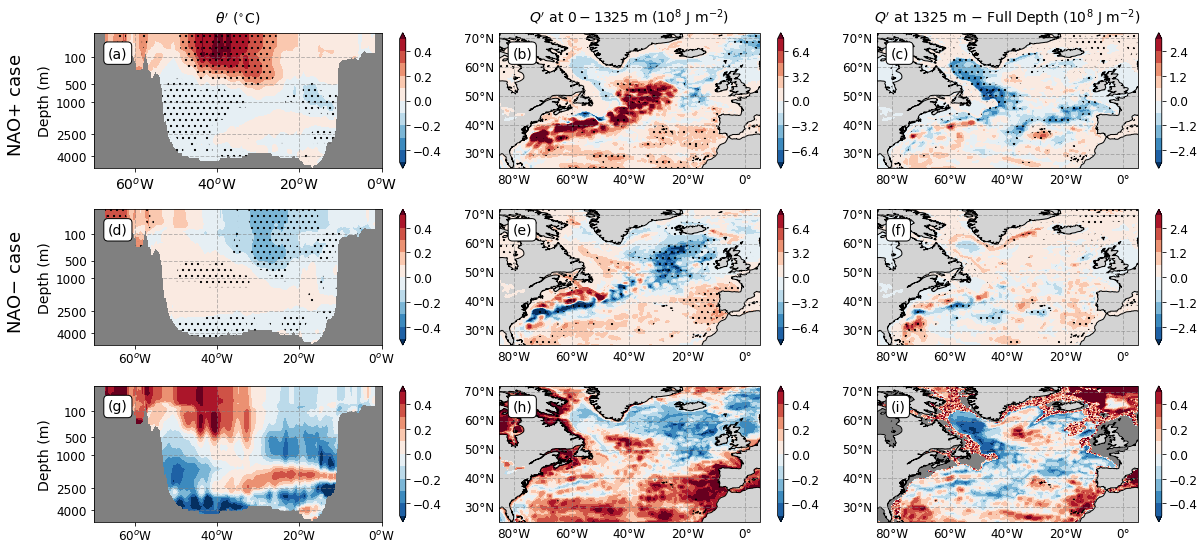

In [29]:
# With bootstrapping and confidence interval

data_dir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

lat_lon_ext = [-85., 5., 25., 72.]
cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

grid1 = plt.GridSpec(3, 3, wspace=0.05, hspace=0.3)
fig = plt.figure(figsize=[20,9])

d1 = xr.open_dataset(data_dir + "../Composite_NAOp_thetao_Depth_Lon.nc", chunks={'time':1, 'comp':1})
d1 = d1.rename({'i':'im'})
lon = d1['longitude']

name = [r'$\theta^{\prime}$ ($^{\circ}$C)', r'$Q^{\prime}$ at $0-1325$ m ($10^{8}$ J m$^{-2}$)', 
        r'$Q^{\prime}$ at 1325 m $-$ Full Depth ($10^{8}$ J m$^{-2}$)'] 

# ------------ NAO+ case -------------------- #

d = xr.open_dataset(data_dir + "Bootstrap_NAOp_thetao_Depth_Lon.nc")
#d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

j = 0
for i in range(4, 5, 3):

    tmp = (d['Heat_Content_1300'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    #titl = str(name[0])
    
    ax = fig.add_subplot(grid1[j, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(98+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    if(i == 4):
        ax.set_title(name[1], pad=10, fontsize=14)
    
    j = j + 1

j = 0
for i in range(4, 5, 3):

    tmp = (d['Heat_Content_1300_full'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-3, vmax=3,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(99+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    ax.set_title(name[2], pad=10, fontsize=14)
    
    j = j + 1


j = 0
for i in range(4, 5, 3):

    tmp = d['thetao'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.)
    tmp = tmp.drop('im').assign_coords(im=lon)
    tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax = fig.add_subplot(grid1[j, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -0.5, vmax = 0.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=12)
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    tmp_cfd = d['thetao_standard_error'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.) * cfd_per * 2.
    tmp_cfd = tmp_cfd.assign_coords(im=lon)
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax.contourf(tmp['im'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    
    plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
    ax.set_ylim([1., 5000.**0.4])
    ax.set_xlim([-70., 0.])
    
    ax.set_ylabel('Depth (m)', fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 14);
    
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
    plt.gca().invert_yaxis()
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(97+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1

    if(i == 4):
        
        ax.text(-0.3, 0.85, r'NAO$+$ case', transform=ax.transAxes, fontsize=18, rotation = 90,
                verticalalignment='top')
        
        ax.set_title(name[0], pad=10, fontsize=14)
        
# ------------ NAO- case -------------------- # 

d = xr.open_dataset(data_dir + "Bootstrap_NAOn_thetao_Depth_Lon.nc")
#d = d.where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) # mask land

j = 1
for i in range(4, 5, 3):

    tmp = (d['Heat_Content_1300'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['standard_error'] = d['Heat_Content_1300_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-8, vmax=8,  
                 lat_lon_ext = lat_lon_ext, levels = 11,  lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(98+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1


j = 1
for i in range(4, 5, 3):

    tmp = d['thetao'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.)
    tmp = tmp.drop('im').assign_coords(im=lon)
    tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax = fig.add_subplot(grid1[j, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -0.5, vmax = 0.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=12)
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    
    tmp_cfd = d['thetao_standard_error'].isel(year=i).where(d1['thetao'].isel(time=0, comp=0) < 100.) * cfd_per * 2.
    tmp_cfd = tmp_cfd.assign_coords(im=lon)
    tmp_cfd = tmp_cfd.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
    ax.contourf(tmp['im'], tmp['lev'], np.abs(tmp) > np.abs(tmp_cfd), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
    
    plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
    ax.set_ylim([1., 5000.**0.4])
    ax.set_xlim([-70., 0.])
    
    ax.set_ylabel('Depth (m)', fontsize=14)
    plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
    
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
    plt.gca().invert_yaxis()
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(97+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1

    if(i == 4):
        
        ax.text(-0.3, 0.85, r'NAO$-$ case', transform=ax.transAxes, fontsize=18, rotation = 90,
                verticalalignment='top')
    
j = 1
for i in range(4, 5, 3):

    tmp = (d['Heat_Content_1300_full'].isel(year=i)).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std = xr.Dataset()
    d_std['confidence_lower'] = d['Heat_Content_1300_full_confidence_lower'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['confidence_upper'] = d['Heat_Content_1300_full_confidence_upper'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    d_std['standard_error'] = d['Heat_Content_1300_full_standard_error'].isel(year=i).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.) / 1e8 # mask land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[j, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-3, vmax=3,  
                 lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
                 title=titl, orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.05, 0.9, '('+chr(99+3*j)+')', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    j = j + 1

# ------------ NAO+ + NAO- cases for lag year = 3 -------------------- # 

count_NAOp = 114
count_NAOn = 133

cb_lim = 0.5
        
dp = xr.open_dataset(data_dir + "Bootstrap_NAOp_thetao_Depth_Lon.nc")
dn = xr.open_dataset(data_dir + "Bootstrap_NAOn_thetao_Depth_Lon.nc")

tmp = (dp['thetao'] / (dp['thetao_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['thetao'] / (dn['thetao_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(d1['thetao'].isel(time=0, comp=0) < 100.)
tmp = tmp.drop('im').assign_coords(im=lon)
tmp = tmp.drop('lev').assign_coords(lev = (d['lev'].values)**0.4) 
    
ax = fig.add_subplot(grid1[2, 0],facecolor='grey')
    
p = tmp.plot.contourf(ax=ax, x='im', y='lev', levels = 11, vmin = -cb_lim, vmax = cb_lim,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = fig.colorbar(p, ax=ax, extend='both')
cb.ax.tick_params(labelsize=12)
plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', r'$20^o$W', r'$0^o$W'], fontsize = 12);

plt.yticks((np.array([100., 500., 1000., 2500., 4000.]))**0.4, [r'100', r'500', r'1000', r'2500', r'4000'])
ax.set_ylim([1., 5000.**0.4])
ax.set_xlim([-70., 0.])
    
ax.set_ylabel('Depth (m)', fontsize=14)
plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);

ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    
plt.gca().invert_yaxis()
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(g)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


tmp = (dp['Heat_Content_1300'] / (dp['Heat_Content_1300_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['Heat_Content_1300'] / (dn['Heat_Content_1300_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.)
    
ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
p = plot_sec(ax, tmp, da_std = d_std, hatching = False, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-cb_lim, vmax=cb_lim,  
             lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
             title=' ', orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(h)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

tmp = (dp['Heat_Content_1300_full'] / (dp['Heat_Content_1300_full_standard_error']* np.sqrt(count_NAOp-1)) + 
       dn['Heat_Content_1300_full'] / (dn['Heat_Content_1300_full_standard_error']* np.sqrt(count_NAOn-1))).isel(year=4).where(ds_NAOp['tos'].isel(comp=0, time=0)< 100.)
    
ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
p = plot_sec(ax, tmp, da_std = d_std, hatching = False, cfd_per = cfd_per, hatch_dense = hatch_dense, vmin=-cb_lim, vmax=cb_lim,  
            lat_lon_ext = lat_lon_ext, levels = 11, lon='nav_lon', lat='nav_lat', cmap='RdBu_r', 
            title=' ', orien='vertical', colorbar=True, y_lab = True, x_lab = True)
    
props = dict(boxstyle='round', facecolor='white')
ax.text(0.05, 0.9, '(i)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.text(1.3, 0.8, 'Lag Year = 3', transform=ax.transAxes, fontsize=14, rotation =90, verticalalignment='top', bbox=props)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure5_new.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure5_new.pdf', dpi=300,bbox_inches='tight');